In [10]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import SGD,  Adam
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from torchsummary import summary
import cv2
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
def normaLize_(img: np.ndarray):
    # Convert grayscale image to RGB
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    resize_img = cv2.resize(img, (32, 32))  # Adjusted size to match model's expected input
    vector = transform(resize_img)
    return vector
            

In [4]:
def get_data(list_dir, threshold):
    data = []
    i = 0
    for i_p in list_dir:
        label = i_p.split(os.path.sep)[-1]
        label = label.split(".")[0]
        if label == "cat": 
            label = 0
        else: 
            label = 1
        img_ = cv2.imread(i_p)
        normalize = normaLize_(img_)
        data.append([normalize, label])
        i += 1
        if i == threshold: 
            break
    return data

In [5]:
path_train = 'D:\\big_data_processing\\source\\lab_5\\dogs-vs-cats\\train'
path_test = 'D:\\big_data_processing\\source\\lab_5\\dogs-vs-cats\\test1'
list_dir_train = list(paths.list_images(path_train))
list_dir_test = list(paths.list_images(path_test))
train_dataset = get_data(list_dir_train, 25000)
train_size = int(0.7 * len(train_dataset))
test_size = len(train_dataset) - train_size
training, validation = random_split(train_dataset, [train_size, test_size])
batch_size = 1024
trainloader = DataLoader(training, batch_size = batch_size,num_workers=10, shuffle  = True)
testloader = DataLoader(validation, batch_size = batch_size, num_workers=10, shuffle = True)

d:\ancoda\Lib\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


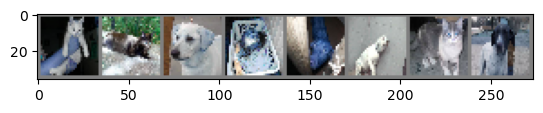

In [6]:
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    imshow(torchvision.utils.make_grid(images[:8])) 
    break

In [7]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=7)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=7)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(8*8*256, 128)
        self.dense2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.relu(self.dense1(x))
        x = self.dense2(x)
        return x

model = CustomModel()
model = model.to(device)

# Print model
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]           4,736
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 20, 20]         100,416
              ReLU-4           [-1, 64, 20, 20]               0
            Conv2d-5          [-1, 128, 14, 14]         401,536
              ReLU-6          [-1, 128, 14, 14]               0
            Conv2d-7            [-1, 256, 8, 8]       1,605,888
              ReLU-8            [-1, 256, 8, 8]               0
           Flatten-9                [-1, 16384]               0
           Linear-10                  [-1, 128]       2,097,280
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 4,211,146
Trainable params: 4,211,146
Non-trainable params: 0
---------------------------

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [9]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [10]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 25

In [11]:
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   
    total = 0            

    for i, (inputs, labels) in enumerate(trainloader, 0):

        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()        

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/25], Loss: 1.4141, Accuracy: 39.70%, Test Loss: 0.7218, Test Accuracy: 49.85%
Epoch [2/25], Loss: 0.7050, Accuracy: 50.65%, Test Loss: 0.7112, Test Accuracy: 49.85%
Epoch [3/25], Loss: 0.6991, Accuracy: 50.95%, Test Loss: 0.6889, Test Accuracy: 55.15%
Epoch [4/25], Loss: 0.6878, Accuracy: 54.66%, Test Loss: 0.6998, Test Accuracy: 51.09%
Epoch [5/25], Loss: 0.6865, Accuracy: 54.14%, Test Loss: 0.6716, Test Accuracy: 59.03%
Epoch [6/25], Loss: 0.6662, Accuracy: 59.16%, Test Loss: 0.6888, Test Accuracy: 55.75%
Epoch [7/25], Loss: 0.6757, Accuracy: 58.18%, Test Loss: 0.6606, Test Accuracy: 59.12%
Epoch [8/25], Loss: 0.6571, Accuracy: 60.89%, Test Loss: 0.6519, Test Accuracy: 60.91%
Epoch [9/25], Loss: 0.6485, Accuracy: 61.89%, Test Loss: 0.6581, Test Accuracy: 59.69%
Epoch [10/25], Loss: 0.6479, Accuracy: 62.33%, Test Loss: 0.6523, Test Accuracy: 60.75%
Epoch [11/25], Loss: 0.6457, Accuracy: 62.67%, Test Loss: 0.6422, Test Accuracy: 62.24%
Epoch [12/25], Loss: 0.6426, Accuracy: 63

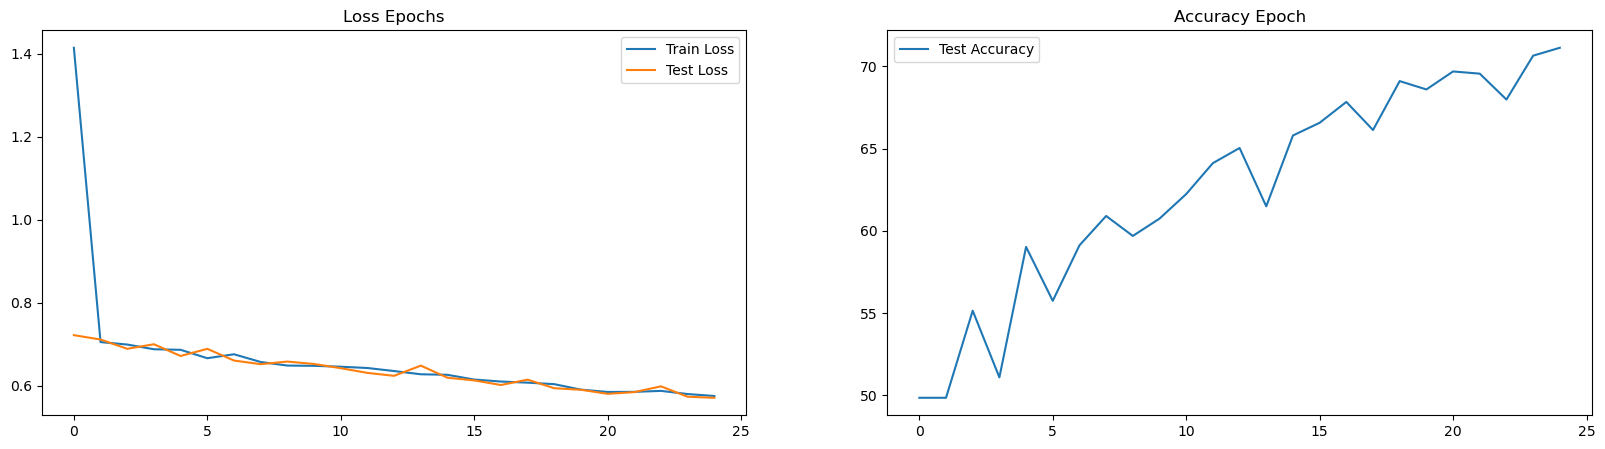

In [13]:
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracies, label = 'Test Accuracy')
plt.legend()